# Texas Covid
Evaluation of Rt for major Texas counties using Kevin Systrom's methodology as described in [this notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb) and deployed at [Rt.live](https://rt.live/)

In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

from scipy.interpolate import interp1d
from scipy import stats as sps

from IPython.display import clear_output

from datetime import datetime
import pandas as pd
import numpy as np
import os
import re

%config InlineBackend.figure_format = 'retina'

In [2]:
# Array for all possible values of Rt
R_T_MAX = 6
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Calculate for only largest TX counties
INCLUDE_COUNTIES = [
    'Dallas',
    'Tarrant',
    'Collin',
    'Denton',
    'Harris',
    'Fort Bend',
    'Travis',
    'Bexar',
]

> __Note__: Daily data comes from the [Texas Dept of Health and Human Services](https://dshs.texas.gov/coronavirus/additionaldata/)

In [3]:
# Read in raw Daily data
df = pd.read_excel(os.path.join('..', 'data', 'Texas COVID-19 Case Count Data by County.xlsx'),
                       skiprows=2,
                       nrows=254, 
                       index_col='County Name')

In [4]:
# Drop population column and parse date headers
if 'Population' in df.columns:
    df = df.drop('Population', axis=1)
    
if df.columns.dtype == 'O':
    date_idx = [datetime.strptime(
                    '2020-'+re.search(r'\n(.+)', c)[1],
                    '%Y-%m-%d'
                )
                for c in df.columns]
    df.columns = date_idx
    
df.head()

,2020-03-04,2020-03-05,2020-03-06,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-15,2020-03-16,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
County Name,,,,,,,,,,,,,,,,,,,,,
Anderson,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,4,6,6,6,8,8
Andrews,0,0,0,0,0,0,0,0,0,0,...,11,11,12,13,13,19,19,19,19,19
Angelina,0,0,0,0,0,0,0,0,0,0,...,16,16,16,17,17,20,23,23,23,23
Aransas,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
Archer,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Prepeare the data by taking a rolling 7-day average of new reported cases in order to smooth out daily variation

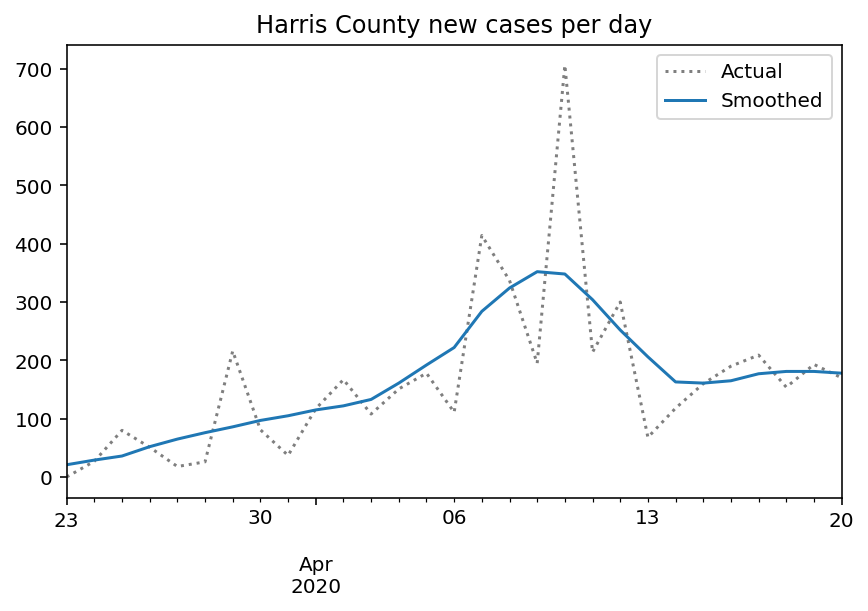

In [20]:
county_name = 'Harris'

def prepare_cases(cases, min_cases=20):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, min_cases)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

original, smoothed = prepare_cases(df.loc[county_name])

original.plot(title=f'{county_name} County new cases per day',
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

### Function for Calculating the Posteriors
Algorithm from [Kevin Systrom](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb), to calculate the posteriors we follow these steps:
1. Calculate $\lambda$ - the expected arrival rate for every day's poisson process
2. Calculate each day's likelihood distribution over all possible values of $R_t$
3. Calculate the process matrix based on the value of $\sigma$ we discussed above
4. Calculate our initial prior because our first day does not have a previous day from which to take the posterior
  - Based on [info from the cdc](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article) we will choose a Gamma with mean 7.
5. Loop from day 1 to the end, doing the following:
  - Calculate the prior by applying the Gaussian to yesterday's prior.
  - Apply Bayes' rule by multiplying this prior and the likelihood we calculated in step 2.
  - Divide by the probability of the data (also Bayes' rule)

In [6]:
def get_posteriors(sr, sigma=0.35):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.35)

Obtain the [highest density intervals](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) for $R_t$ by day:

In [7]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
2020-04-16,0.13,1.26
2020-04-17,0.44,1.66
2020-04-18,0.46,1.67
2020-04-19,0.41,1.61
2020-04-20,0.35,1.54


### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [8]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)
result.tail()

,ML,Low_90,High_90
2020-04-16,0.71,0.13,1.26
2020-04-17,1.08,0.44,1.66
2020-04-18,1.11,0.46,1.67
2020-04-19,1.05,0.41,1.61
2020-04-20,0.96,0.35,1.54


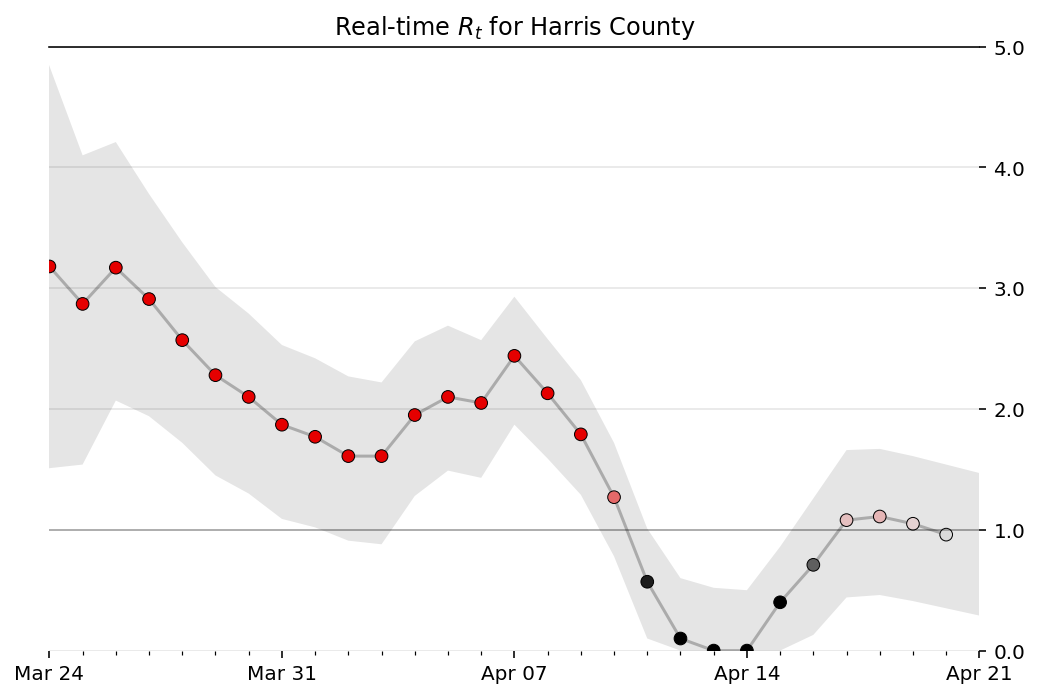

In [9]:
def plot_rt(result, ax, name):
    
    ax.set_title(f'{name} County')
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values(0)
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-05'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-24'), result.index.get_level_values(0)[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, county_name)
ax.set_title(f'Real-time $R_t$ for {county_name} County')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Choosing the optimal $\sigma$

See Kevin Systrom's [notebook](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb) for detail on selection of the optimal $\sigma$ parameter

In [10]:
sigmas = np.linspace(1/20, 1, 20)

results = {}

for county in INCLUDE_COUNTIES:
    cases = df.loc[county]
    
    print(county)
    new, smoothed = prepare_cases(cases, min_cases=20)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[county] = result
    clear_output(wait=True)

print('Done.')

Done.


Now that we have all the log likelihoods, we can sum for each value of sigma across counties, graph it, then choose the maximum.

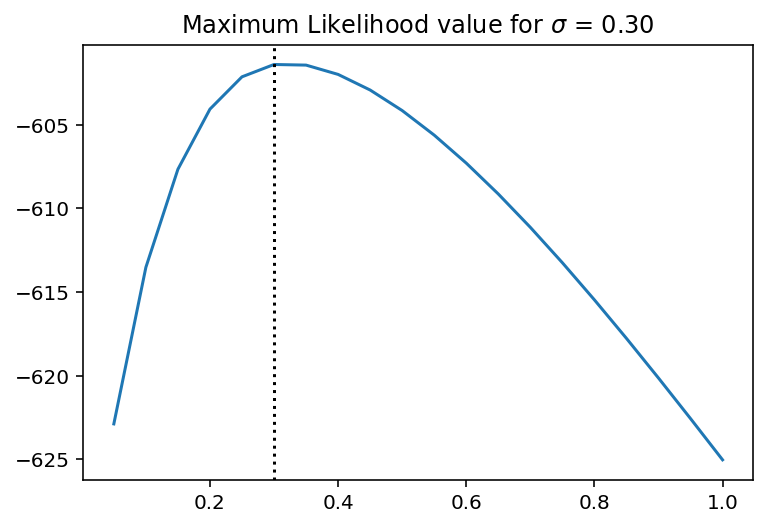

In [11]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")
plt.show()

### Compile Final Results

Given that we've selected the optimal $\sigma$, let's grab the precalculated posterior corresponding to that value of $\sigma$ for each county. Let's also calculate the 90% and 50% highest density intervals (this takes a little while) and also the most likely value.

In [12]:
final_results = {}

for county, result in results.items():
    print(county)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    final_results[county] = result
    clear_output(wait=True)

print('Done.')

Done.


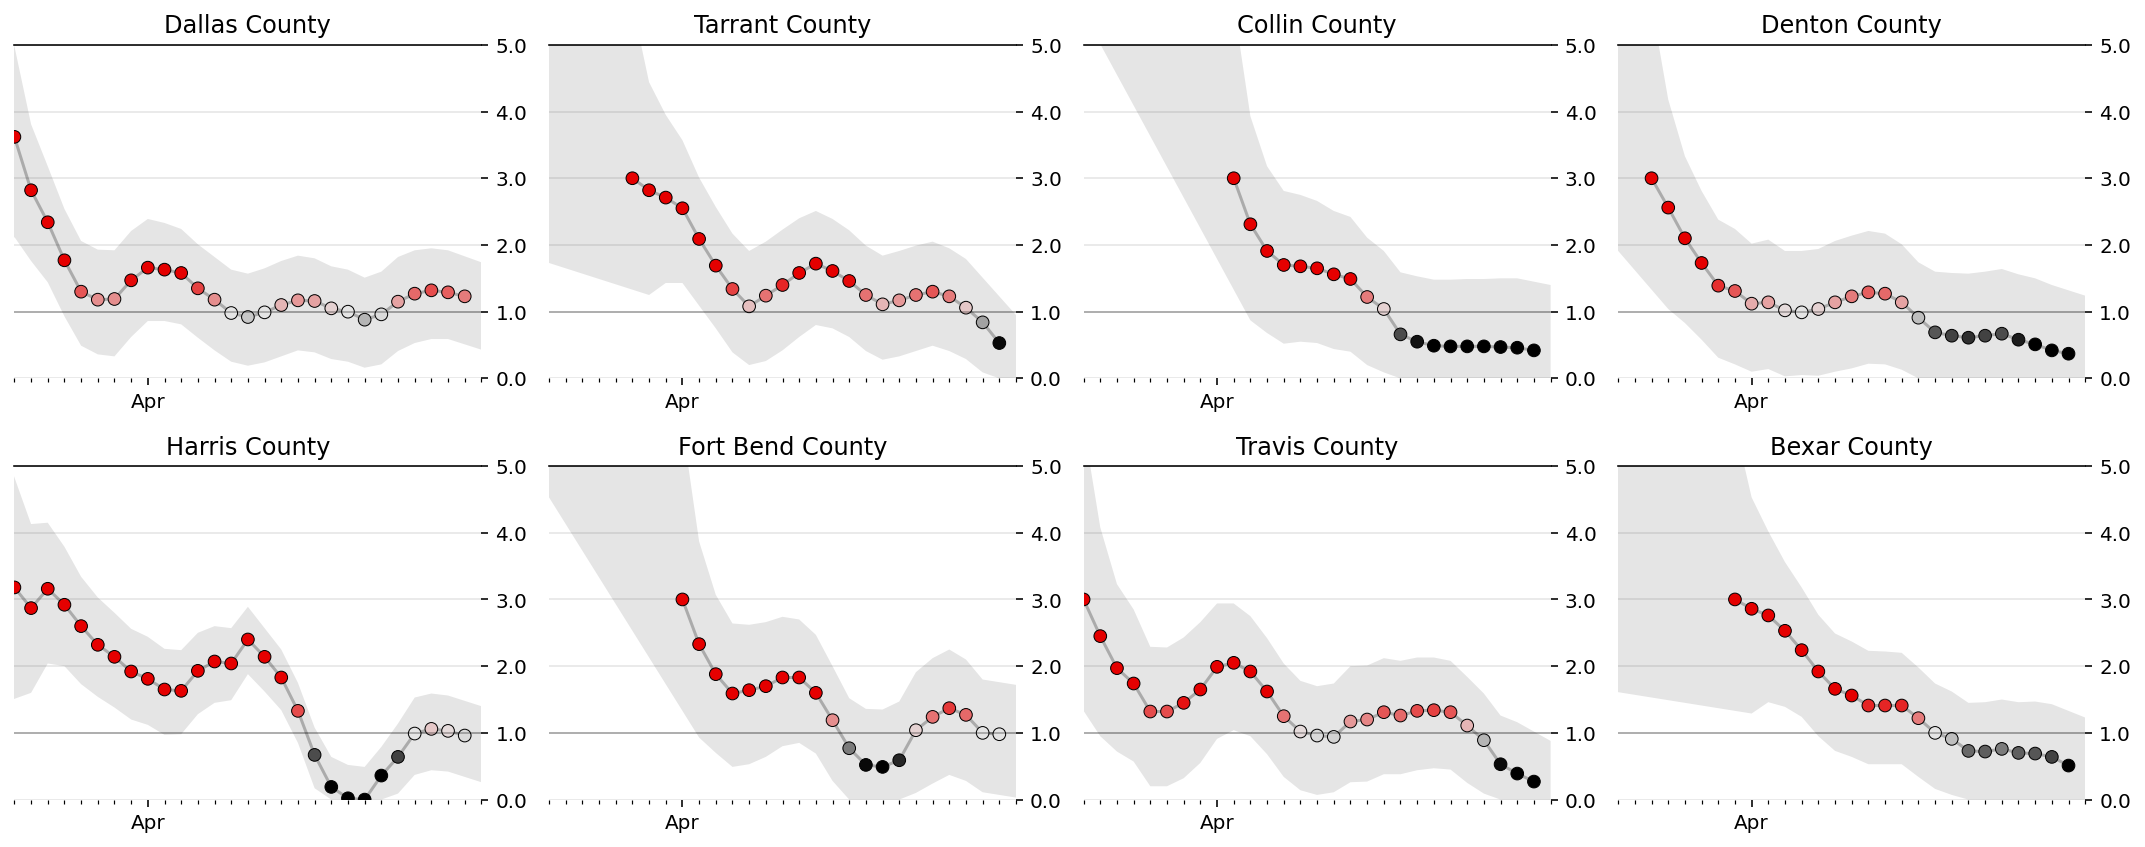

In [13]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (county, result) in enumerate(final_results.items()):
    plot_rt(result, axes.flat[i], county)

fig.tight_layout()
fig.set_facecolor('w')

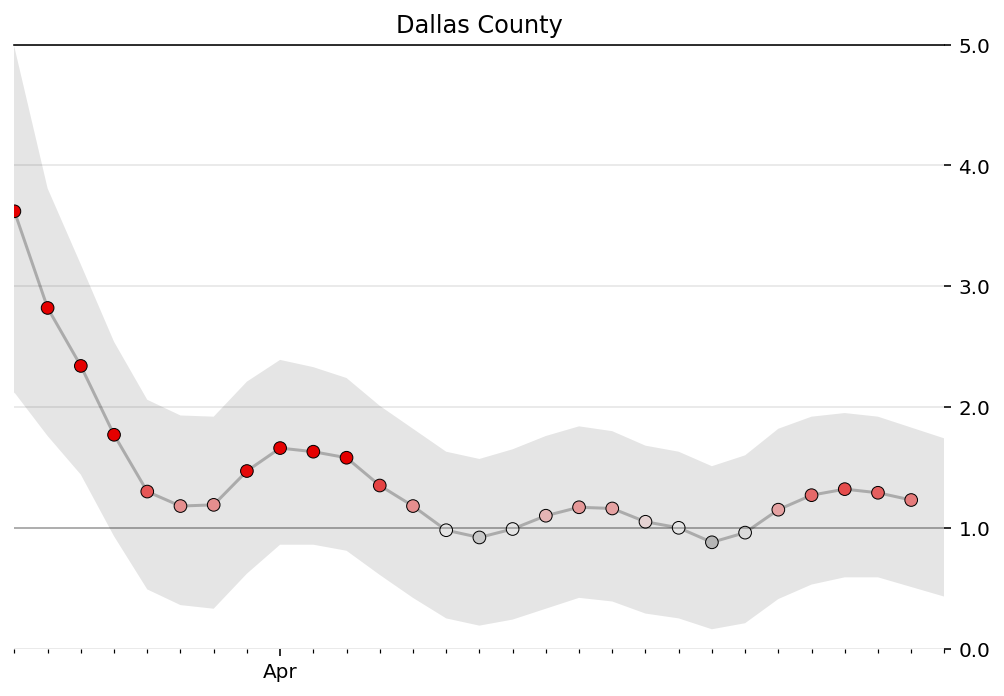

In [36]:
# The entire process for a given county and sigma
county = 'Dallas'
sigma = 0.3

# Get smoothed new case values
_, smoothed = prepare_cases(df.loc[county], 
                              min_cases=20)

# Get previous values of Rt
posteriors, _ = get_posteriors(smoothed, 
                               sigma=sigma)

# Return intervals and plot
hdis_90 = highest_density_interval(posteriors, p=.9)
most_likely = posteriors.idxmax().rename('ML')
result = pd.concat([most_likely, hdis_90], axis=1)

fig, ax = plt.subplots(figsize=(600/72,400/72))
plot_rt(result, ax, county)